Install required libraries

In [1]:
# Install required packages
%pip install opencv-python matplotlib numpy pandas scikit-learn tensorflow pillow seaborn


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.9 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.9 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 538.8 kB/s eta 0:00:00
     ---------------------------------------- 0.0/108.7 kB ? eta -:--:--
     ------------------ -------------------- 51.2/108.7 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 108.7/108.7 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 3.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   -----


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import Libraries and Set Up

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from PIL import Image

# Set random seed for reproducibility
np.random.seed(42)


Parse Both Training and Testing Annotations

In [13]:
# Paths - update these according to your folder structure
train_images_dir = 'C:/Users/Venu Gopal/Downloads/tsrd-train'
test_images_dir = 'C:/Users/Venu Gopal/Downloads/TSRD-Test'
train_annotations = 'C:/Users/Venu Gopal/Downloads/TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt'
test_annotations = 'C:/Users/Venu Gopal/Downloads/TSRD-Test Annotation/TsignRecgTest1994Annotation.txt'

def parse_annotations(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(';')
            if len(parts) >= 8:  # Ensure we have all required fields
                filename = parts[0]
                x1, y1, width, height, x2, y2, class_id = map(int, parts[1:8])
                data.append({
                    'filename': filename,
                    'x1': x1, 'y1': y1, 'width': width, 'height': height,
                    'x2': x2, 'y2': y2, 'class_id': class_id
                })
    return pd.DataFrame(data)

# Load training data
train_df = parse_annotations(train_annotations)
# Load testing data
test_df = parse_annotations(test_annotations)


Load and Preprocess Training and Testing Images

In [14]:
def load_and_preprocess_images(df, images_dir, img_size=(32, 32)):
    images = []
    labels = []
    for idx, row in df.iterrows():
        img_path = os.path.join(images_dir, row['filename'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype('float32') / 255.0
                images.append(img)
                labels.append(row['class_id'])
        else:
            print(f"Image not found: {img_path}")
    return np.array(images), np.array(labels)

# Load and preprocess images
print("Loading and preprocessing images...")
X_train, y_train = load_and_preprocess_images(train_df, train_images_dir)
X_test, y_test = load_and_preprocess_images(test_df, test_images_dir)


Loading and preprocessing images...


Visualize Sample Data

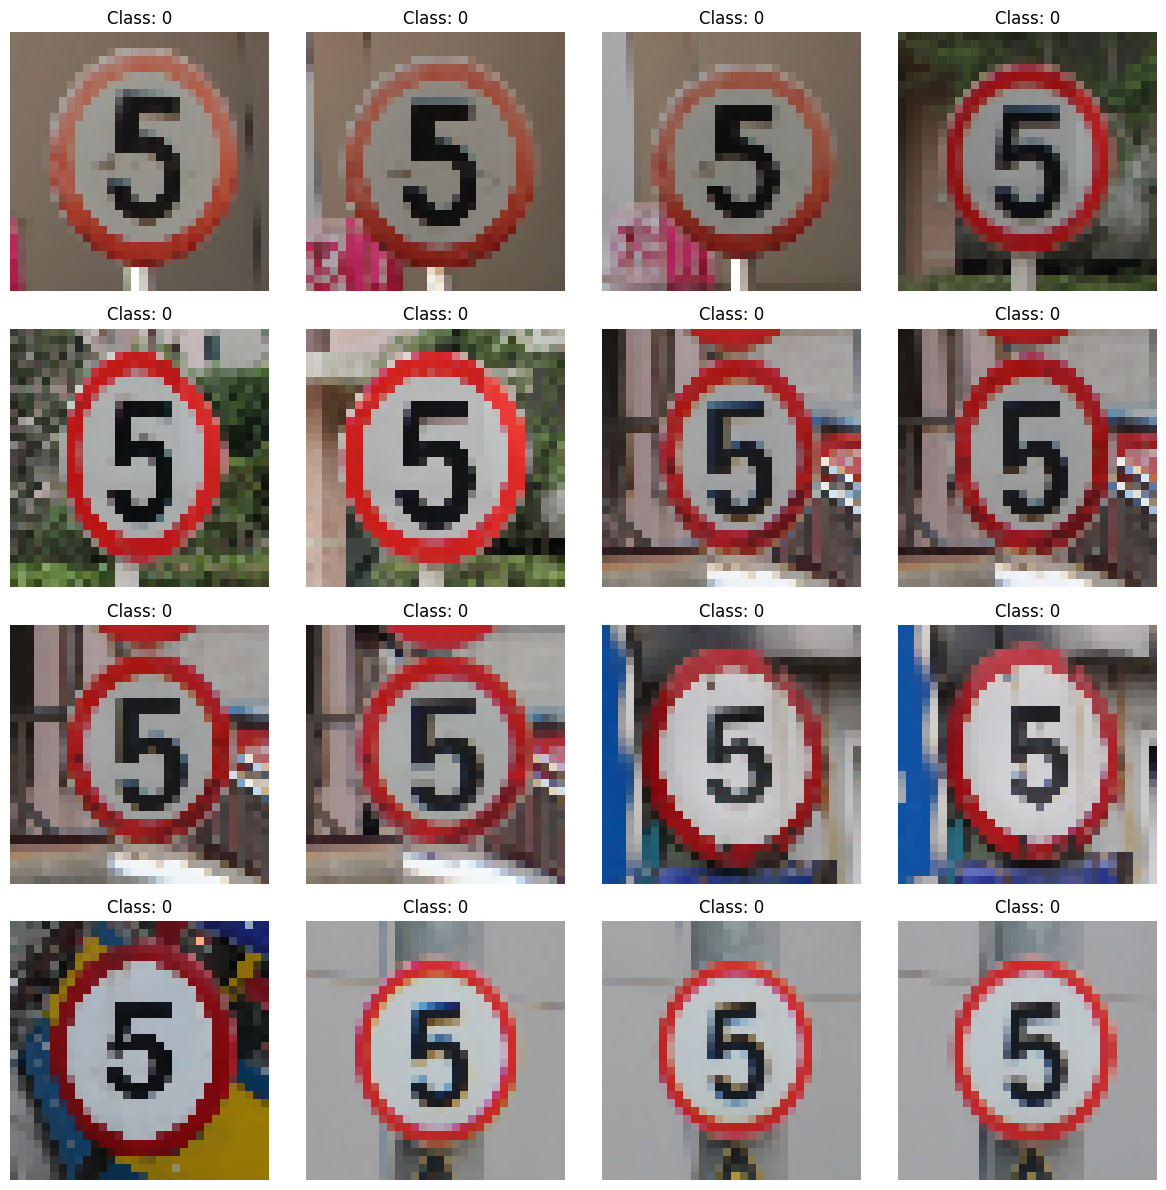

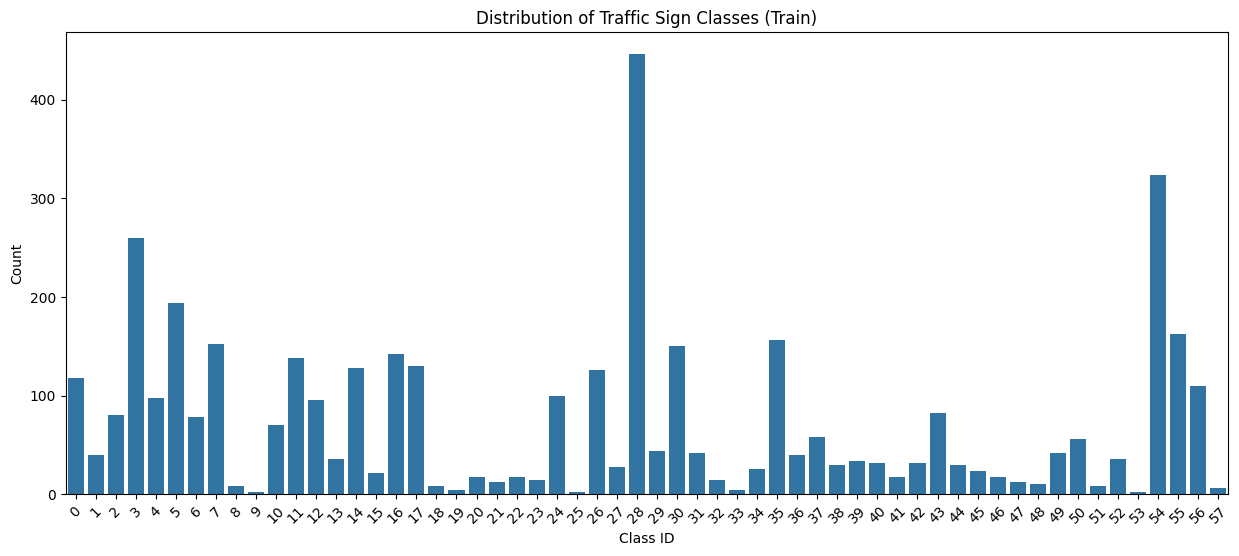

In [15]:
def plot_sample_images(X, y, num_samples=16):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()
    for i in range(num_samples):
        if i < len(X):
            axes[i].imshow(X[i])
            axes[i].set_title(f'Class: {y[i]}')
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(X_train, y_train)

plt.figure(figsize=(15, 6))
sns.countplot(x=y_train)
plt.title('Distribution of Traffic Sign Classes (Train)')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Prepare Data for Training

In [16]:
num_classes = np.max(y_train) + 1  # Number of classes is max label + 1
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

# Split training data into train and validation (optional, but recommended)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_categorical, test_size=0.2, random_state=42
)


Build CNN Model

In [17]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_cnn_model((32, 32, 3), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\Venu Gopal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 58)             │         3,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,938 (667.73 KB)

 Trainable params: 170,938 (667.73 KB)

 Non-trainable params: 0 (0.00 B)

Data Augmentation and Training

In [18]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

history = model.fit(
    datagen.flow(X_train_split, y_train_split, batch_size=32),
    steps_per_epoch=len(X_train_split) // 32,
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=1
)


c:\Users\Venu Gopal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0699 - loss: 3.8647 - val_accuracy: 0.1871 - val_loss: 3.2847
Epoch 2/20
  1/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0625 - loss: 3.4520

c:\Users\Venu Gopal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0625 - loss: 3.4520 - val_accuracy: 0.1966 - val_loss: 3.2605
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1731 - loss: 3.2664 - val_accuracy: 0.2986 - val_loss: 2.7124
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1875 - loss: 2.8529 - val_accuracy: 0.2986 - val_loss: 2.7123
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2812 - loss: 2.7726 - val_accuracy: 0.2974 - val_loss: 2.5688
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1875 - loss: 2.6334 - val_accuracy: 0.2938 - val_loss: 2.5950
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2702 - loss: 2.6207 - val_accuracy: 0.3357 - val_loss: 2.2385
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 2.6303 - val_accuracy: 0.3321 - val_loss: 2.2305
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3262 - loss: 2.3358 - val_accuracy: 0.4017 - 

Save the Model

In [19]:
model.save('traffic_sign_cnn_model.h5')
print("Model saved as 'traffic_sign_cnn_model.h5'")


Model saved as 'traffic_sign_cnn_model.h5'


Evaluate Model Performance

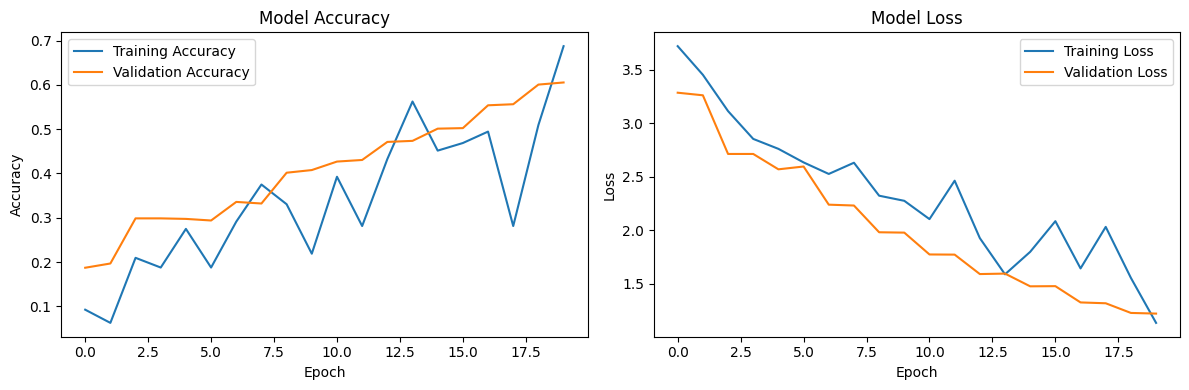

Test Accuracy: 0.4283
Test Loss: 1.7895


In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
